<a href="https://colab.research.google.com/github/chrismilleruk/gradientci/blob/main/wandb/eval-hyperparameter-sweeps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Dive In!
You know how sweeps work on a fundamental level. Now let's use them with a real model.

In [1]:
# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold

# Models
import tensorflow
from tensorflow import keras
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping

# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import random
random.seed(42)
import imageio
import PIL
import os
import itertools
import glob
import cv2, glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
%matplotlib inline

# Ignore excessive warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setup
Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library


In [2]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.9MB 15.7MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 163kB 59.4MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 133kB 59.5MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 


## Explore The Simpsons Dataset

In [3]:
# Fetch the dataset form Github
!git clone https://github.com/lavanyashukla/simpsons-dataset.git

Cloning into 'simpsons-dataset'...
remote: Enumerating objects: 21934, done.
remote: Total 21934 (delta 0), reused 0 (delta 0), pack-reused 21934
Receiving objects: 100% (21934/21934), 590.28 MiB | 38.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (42860/42860), done.


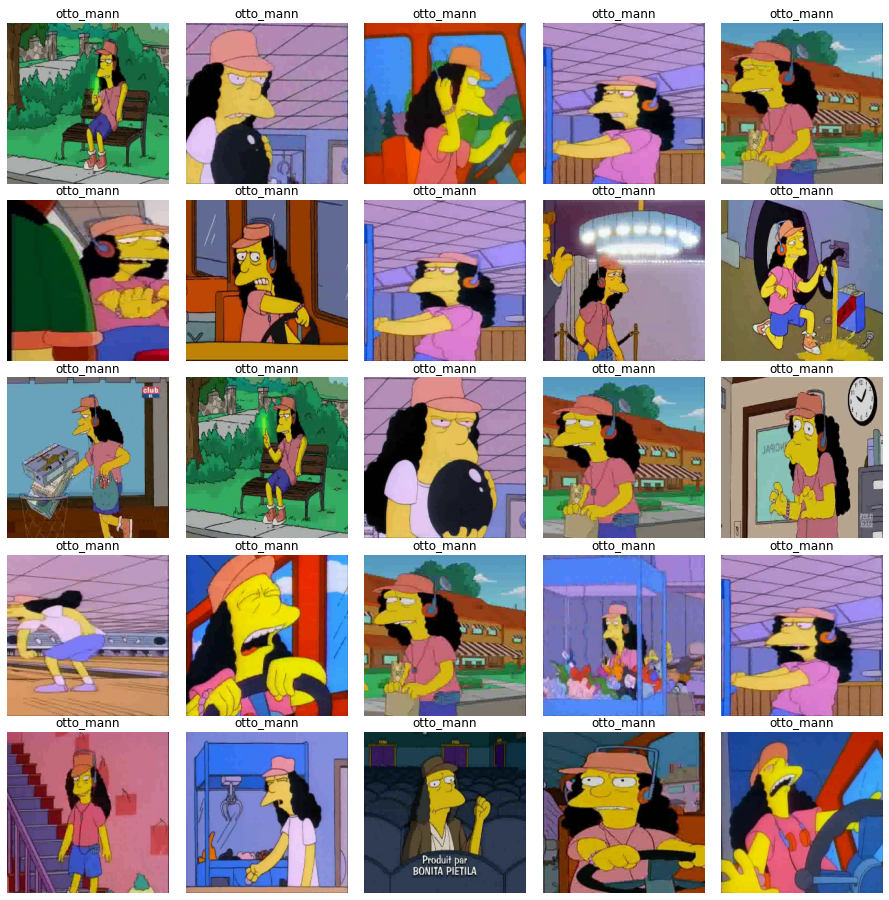

In [25]:
# Visualize images in the dataset
# characters = glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/**')
characters = glob.glob('simpsons-dataset/simpsons_dataset/simpsons_dataset/*/**')
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0, hspace=0.1)
i = 0
for character in characters[:25]:
    img = cv2.imread(character)
    img = cv2.resize(img, (250, 250))
    plt.subplot(5, 5, i+1)
    plt.title(character.split('/')[-2])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    i += 1

In [26]:
# Define the labels for the Simpsons characters we're detecting
character_names = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lenny_leonard', 11:'lisa_simpson',
        12: 'marge_simpson', 13: 'mayor_quimby',14:'milhouse_van_houten', 15: 'moe_szyslak', 
        16: 'ned_flanders', 17: 'nelson_muntz', 18: 'principal_skinner', 19: 'sideshow_bob'}
img_size = 64
num_classes = 20
dir = "simpsons-dataset/simpsons_dataset/simpsons_dataset"

# Load training data
X_train = []
y_train = []
for label, name in character_names.items():
   list_images = os.listdir(dir+'/'+name)
   for image_name in list_images:
       image = imageio.imread(dir+'/'+name+'/'+image_name)
       X_train.append(cv2.resize(image, (img_size,img_size)))
       y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split data for cross validation  
X_test = X_train[-100:] 
y_test = y_train[-100:]

X_train = X_train[:-100] 
y_train = y_train[:-100]


# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode the labels (neural nets only like numbers)
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [27]:
len(X_train), len(y_train), len(X_test), len(y_test)

(19448, 19448, 100, 100)

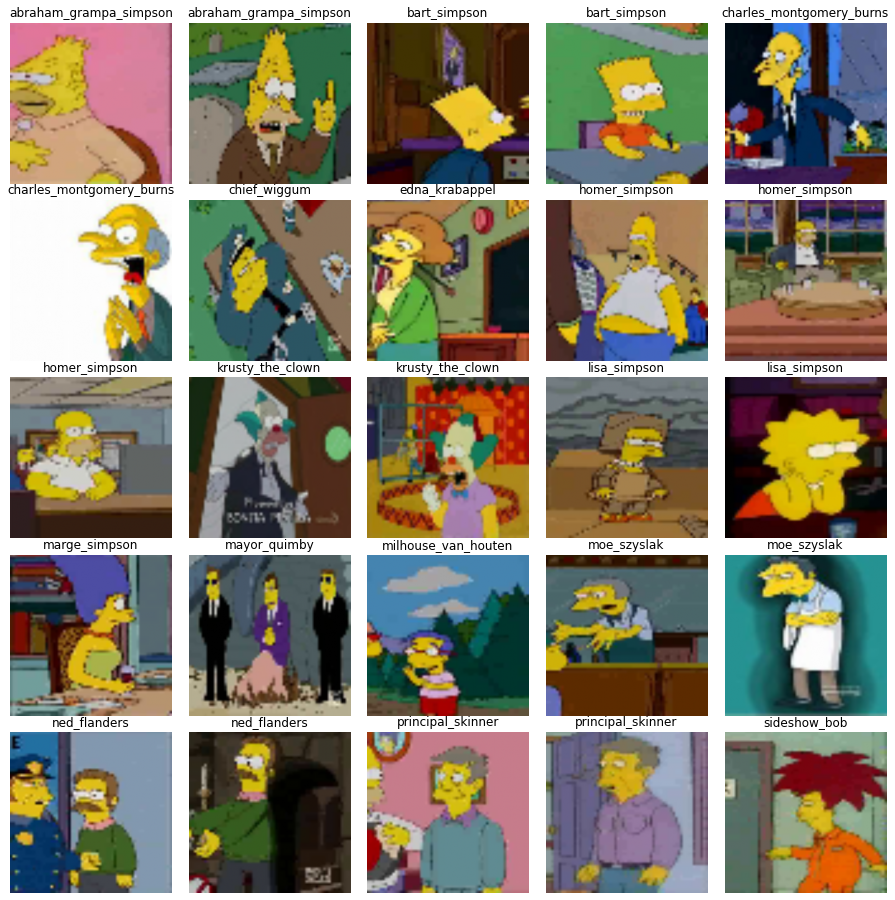

In [28]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0, hspace=0.1)
p = 1
for i in range(0, len(X_train), len(X_train)//24):
    img = X_train[i]
    label = character_names[y_train[i].argmax(0)]
    img = cv2.resize(img, (250, 250))
    plt.subplot(5, 5, p)
    p += 1
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')


# Run A Sweep

1.   List item
2.   List item



As you'll recall there are just 3 simple steps to running a sweep:

**1. Define the sweep**

**2. Initialize the sweep**

**3. Run the sweep agent**

Let's walk through each step in more detail.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034183402_Screenshot+2019-10-25+13.09.37.png)

## Retrieve the best model

In [ ]:
# api = wandb.Api()
# entity="sweep"
# project="simpsons"
# run_id = "33mwvwek"
# run = api.run(entity + "/" + project + "/" + run_id)

In [ ]:
# run.file("model-best.h5").download()

In [20]:
sweep_id = "uqg7jmld"

import wandb
api = wandb.Api()
sweep = api.sweep(entity + "/" + project + "/" + sweep_id)
runs = sorted(sweep.runs, key=lambda run: run.summary.get("val_accuracy", 0), reverse=True)
val_acc = runs[0].summary.get("val_accuracy", 0)
print(f"Best run {runs[0].name} with {val_acc}% validation accuracy")

runs[0].file("model-best.h5").download(replace=True)
print("Best model saved to model-best.h5")

Best run gallant-sweep-26 with 0.9900000095367432% validation accuracy
Best model saved to model-best.h5


## Load the model

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('model-best.h5')

# Show the model architecture
model.summary()

In [148]:
def get_prediction(x, y):
  if x.max() > 1: 
    image = x
  else:
    image = x.astype('int') * 255
  character = character_names[y]

  # Resize image and normalize it
  pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
  
  # Get predictions for the character
  prediction = model.predict(pic.reshape(1, 64, 64, 3))[0]
  
  # Get true name of the character
  name = character.split('_')[0].title()
  
  # Format predictions to string to overlay on image
  text = sorted(['{:s} : {:.1f}%'.format(character_names[k].split('_')[0].title(), 100*v) for k,v in enumerate(prediction)], 
      key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
  


  # Upscale image
  # if x.max() > 1: 
  #   img = cv2.resize(x.astype('float32') / 255, (352, 352))
  # else:
  img = cv2.resize(x, (352, 352))
  
  # Create background to overlay text on
  cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
  
  # Add text to image
  font = cv2.FONT_HERSHEY_DUPLEX
  cv2.putText(img, 'Name : %s' % name, (10, 280), font, 0.7,(73,79,183), 2, cv2.LINE_AA)
  for k, t in enumerate(text):
      color = (10,100,10) if name in t else (80,0,0)
      cv2.putText(img, t, (10, 300+k*18), font, 0.65, color, 2, cv2.LINE_AA)
  
  title = "%s: %s" % (name, text[0])

  return img, title
        

def predict():
  predicted_images = []
  for i in range(20):
    character = character_names[i]
    # Read in a character image from the test dataset
    image = cv2.imread(np.random.choice([k for k in glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/*.*') if character in k]))
    
    # print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    print(i, image.dtype, image.shape, image.min(), image.max())

    (img, title) = get_prediction(image, i)
    predicted_images.append((img, title))     

    # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # # Resize image and normalize it
    # pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
    
    # # Get predictions for the character
    # prediction = model.predict(pic.reshape(1, 64, 64,3))[0]
    
    # # Get true name of the character
    # name = character.split('_')[0].title()
    
    # # Format predictions to string to overlay on image
    # text = sorted(['{:s} : {:.1f}%'.format(character_names[k].split('_')[0].title(), 100*v) for k,v in enumerate(prediction)], 
    #     key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    
    # # Upscale image
    # img = cv2.resize(img, (352, 352))
    
    # # Create background to overlay text on
    # cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    
    # # Add text to image
    # font = cv2.FONT_HERSHEY_DUPLEX
    # cv2.putText(img, 'Name : %s' % name, (10, 280), font, 0.7,(73,79,183), 2, cv2.LINE_AA)
    # for k, t in enumerate(text):
    #     color = (10,100,10) if name in t else (80,0,0)
    #     cv2.putText(img, t, (10, 300+k*18), font, 0.65, color, 2, cv2.LINE_AA)
        
    # # Add predicted image from test dataset with annotations to array
    # predicted_images.append((img, "%s: %s" % (name, text[0])))     
  return predicted_images


In [149]:
predicted = predict()

0 uint8 (149, 103, 3) 0 253
1 uint8 (171, 114, 3) 0 249
2 uint8 (171, 229, 3) 0 248
3 uint8 (154, 206, 3) 0 242
4 uint8 (171, 114, 3) 0 234
5 uint8 (70, 92, 3) 0 228
6 uint8 (42, 38, 3) 0 238
7 uint8 (149, 103, 3) 0 248
8 uint8 (90, 105, 3) 0 255
9 uint8 (171, 114, 3) 0 240
10 uint8 (154, 206, 3) 0 219
11 uint8 (149, 206, 3) 0 255
12 uint8 (171, 114, 3) 0 240
13 uint8 (149, 103, 3) 0 255
14 uint8 (171, 114, 3) 0 226
15 uint8 (68, 92, 3) 0 255
16 uint8 (90, 117, 3) 0 255
17 uint8 (126, 223, 3) 0 241
18 uint8 (171, 229, 3) 0 235
19 uint8 (171, 229, 3) 0 255


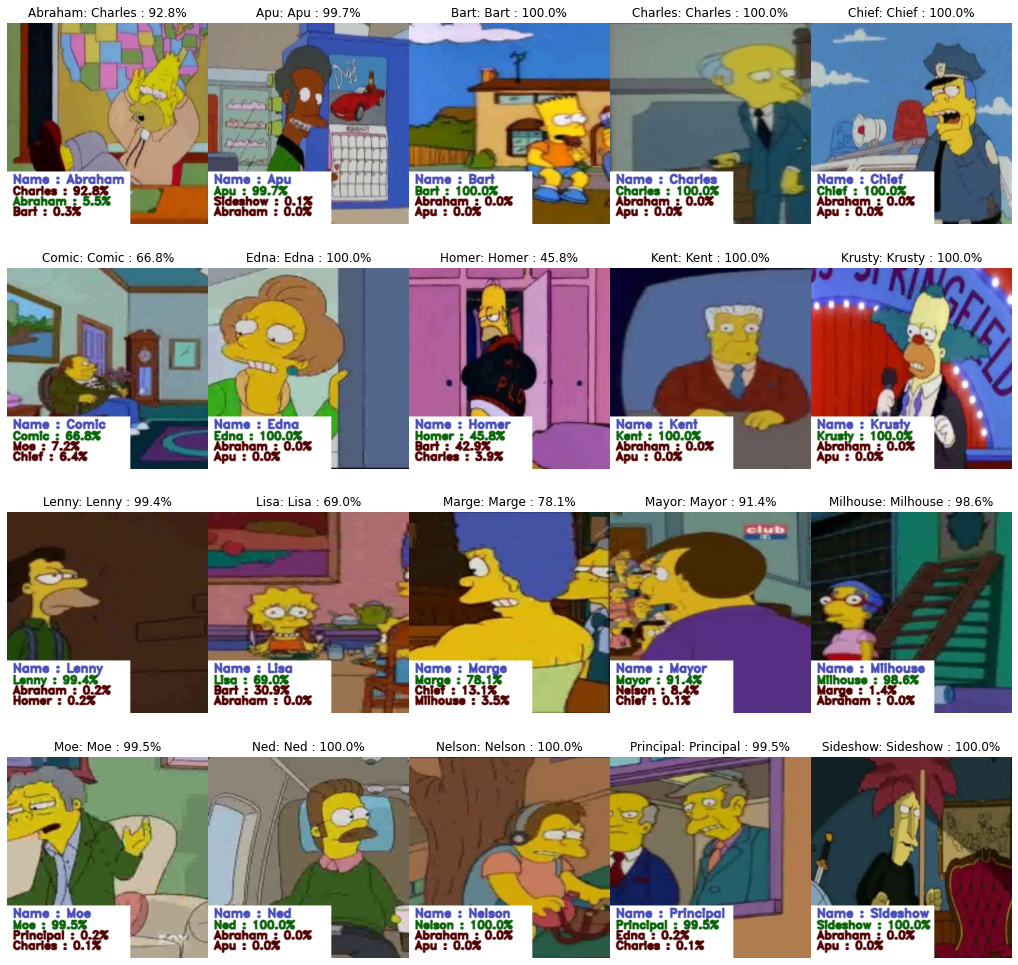

In [145]:
plt.figure(figsize=(18,18))
plt.subplots_adjust(wspace=0, hspace=0)
p = 1
for i in range(0, len(predicted)):
    img = predicted[i][0]
    label = predicted[i][1]
    # img = cv2.resize(img, (250, 250))
    plt.subplot(4, 5, p)
    p += 1
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')


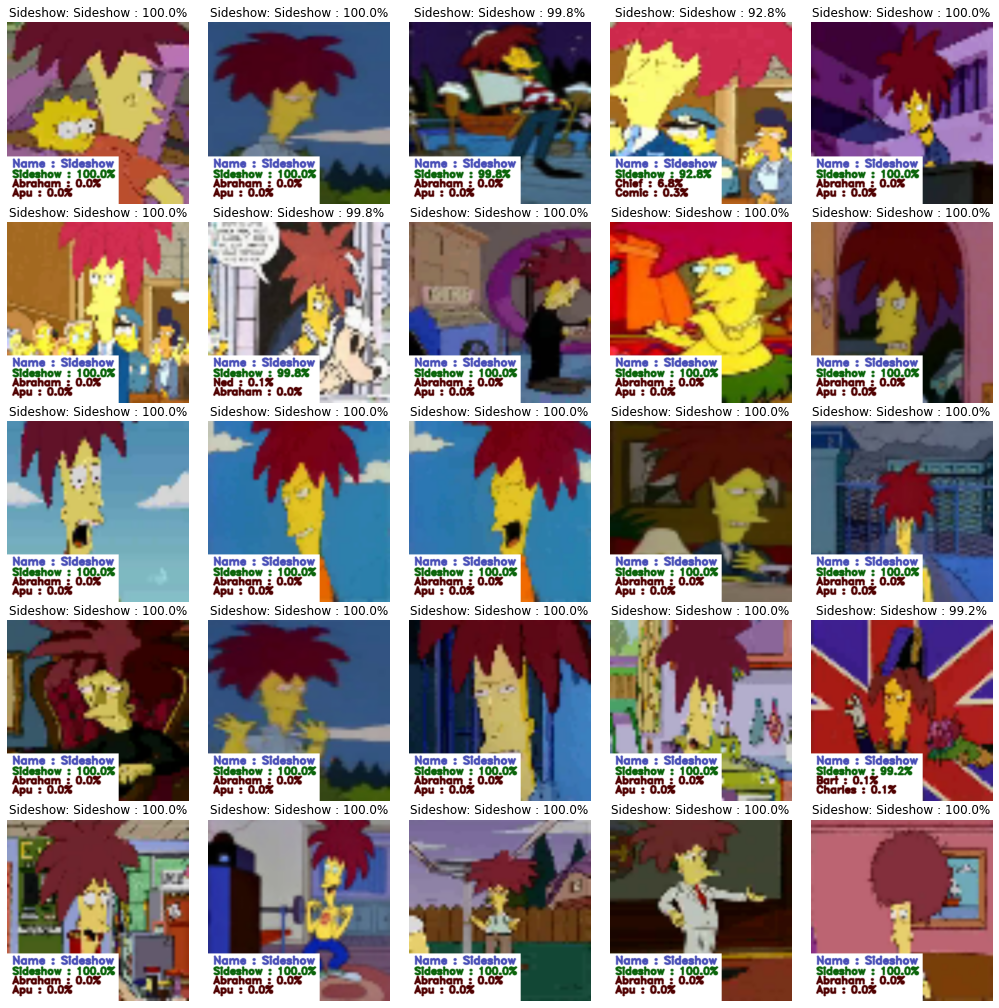

In [152]:
plt.figure(figsize=(18,18))
plt.subplots_adjust(wspace=0, hspace=0.1)
p = 1
for i in range(0, len(X_test), len(X_test) // 24):
    plt.subplot(5, 5, p)
    p += 1

    x = (X_test[i] * 255).astype('uint8')
    y = y_test[i].argmax()

    # print(i, x.dtype, x.min(), x.max())

    # plt.imshow(X_test[i])
    # plt.title('%d: %s' % (i, character_names[y]) )
    # plt.axis('off')

    (img, label) = get_prediction(x, y)

    # print(i, img.dtype, img.min(), img.max())

    plt.imshow( img )
    plt.title( label )
    plt.axis('off')


### Define Your Neural Network
Before we can run the sweep, let's define a function that creates and trains our neural network.

In the function below, we define a simplified version of a VGG19 model in Keras, and add the following lines of code to log models metrics, visualize performance and output and track our experiments easily:
*   **wandb.init()** – Initialize a new W&B run. Each run is single execution of the training script.
*   **wandb.config** – Save all your hyperparameters in a config object. This lets you use our app to sort and compare your runs by hyperparameter values.
*   **callbacks=[WandbCallback()]** – Fetch all layer dimensions, model parameters and log them automatically to your W&B dashboard.
*   **wandb.log()** – Logs custom objects – these can be images, videos, audio files, HTML, plots, point clouds etc. Here we use wandb.log to log images of Simpson characters overlaid with actual and predicted labels.

In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 2,
        'batch_size': 128,
        'weight_decay': 0.0005,
        'learning_rate': 1e-3,
        'activation': 'relu',
        'optimizer': 'nadam',
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Determine input shape
    input_shape = (X_train.shape[1], X_train.shape[2], 3)
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # Set of Conv2D, Conv2D, MaxPooling2D layers with 32 and 64 filters
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 128 filters
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 256 filters
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Another set of Conv2D, Conv2D, MaxPooling2D layers with 512 filters
    model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(filters = 1024, kernel_size = (3, 3), padding = 'same', 
                     activation ='relu', input_shape = input_shape, kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten
    model.add(Flatten())
    model.add(Dense(512, activation ='relu', kernel_regularizer=regularizers.l2(config.weight_decay)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation = "softmax"))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(lr=config.learning_rate, decay=1e-5, momentum=0.9, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(lr=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    #data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)
    
    model.fit(datagen.flow(X_train, y_train, batch_size=config.batch_size),
                        steps_per_epoch=64, #len(X_train) / 128, 
                        epochs=config.epochs,
                        validation_data=(X_test, y_test),
                        callbacks=[WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=character_names),
                                   keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                                   ])
    
    predicted_images = []
    for i in range(20):
      character = character_names[i]
      # Read in a character image from the test dataset
      image = cv2.imread(np.random.choice([k for k in glob.glob('simpsons-dataset/kaggle_simpson_testset/kaggle_simpson_testset/*.*') if character in k]))
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
      # Resize image and normalize it
      pic = cv2.resize(image, (64, 64)).astype('float32') / 255.
      
      # Get predictions for the character
      prediction = model.predict(pic.reshape(1, 64, 64,3))[0]
      
      # Get true name of the character
      name = character.split('_')[0].title()
      
      # Format predictions to string to overlay on image
      text = sorted(['{:s} : {:.1f}%'.format(character_names[k].split('_')[0].title(), 100*v) for k,v in enumerate(prediction)], 
         key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
      
      # Upscale image
      img = cv2.resize(img, (352, 352))
      
      # Create background to overlay text on
      cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
      
      # Add text to image
      font = cv2.FONT_HERSHEY_DUPLEX
      cv2.putText(img, 'True Name : %s' % name, (10, 280), font, 0.7,(73,79,183), 2, cv2.LINE_AA)
      for k, t in enumerate(text):
          cv2.putText(img, t, (10, 300+k*18), font, 0.65,(0,0,0), 2, cv2.LINE_AA)
          
      # Add predicted image from test dataset with annotations to array
      predicted_images.append(wandb.Image(img, caption="%s: %s" % (name, text[0])))     
          
    # Log images from test set to wandb automatically, along with predicted and true labels by passing pytorch tensors with image data into wandb.Image
    wandb.log({"predictions": predicted_images})

## 3. Run the sweep agent

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: ftz6fspa with config:
wandb: 	activation: elu
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 128
wandb: 	epochs: 20
wandb: 	layer: LSTM
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/20
64/64 [==============================] - 16s 211ms/step - loss: 6.3840 - accuracy: 0.0623 - val_loss: 5.1677 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 15s 226ms/step - loss: 5.9246 - accuracy: 0.1039 - val_loss: 5.1125 - val_accuracy: 0.0000e+00
Epoch 3/20
64/64 [==============================] - 14s 219ms/step - loss: 5.5156 - accuracy: 0.1493 - val_loss: 4.9302 - val_accuracy: 0.0000e+00
Epoch 4/20
64/64 [==============================] - 15s 224ms/step - loss: 5.3276 - accuracy: 0.1951 - val_loss: 4.4368 - val_accuracy: 0.0000e+00
Epoch 5/20
64/64 [==============================] - 15s 227ms/step - loss: 5.0975 - accuracy: 0.2267 - val_loss: 3.4816 - val_accuracy: 0.5300
Epoch 6/20
64/64 [==============================] - 14s 217ms/step - loss: 5.0158 - accuracy: 0.2459 - val_loss: 2.8767 - val_accuracy: 0.8700
Epoch 7/20
64/64 [==============================] - 14s 214ms/step - loss: 4.8262 - accuracy: 0.2787 - val_loss: 4.3108 - val_

wandb: Agent Starting Run: q70bmk6v with config:
wandb: 	activation: selu
wandb: 	conv_layer_size: 32
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 10
wandb: 	layer: LSTM
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10
64/64 [==============================] - 16s 201ms/step - loss: 5.7062 - accuracy: 0.1439 - val_loss: 5.2952 - val_accuracy: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 15s 228ms/step - loss: 4.6115 - accuracy: 0.3439 - val_loss: 7.5631 - val_accuracy: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 14s 208ms/step - loss: 4.1186 - accuracy: 0.4607 - val_loss: 6.8116 - val_accuracy: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 14s 203ms/step - loss: 3.6637 - accuracy: 0.5501 - val_loss: 5.9906 - val_accuracy: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 13s 201ms/step - loss: 3.3580 - accuracy: 0.6213 - val_loss: 6.4812 - val_accuracy: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 13s 202ms/step - loss: 2.9878 - accuracy: 0.6986 - val_loss: 4.8746 - val_accuracy: 0.0300
Epoch 7/10
64/64 [==============================] - 15s 228ms/step - loss: 2.7855 - accuracy: 0.7358 - val_loss: 5.3453 - 

wandb: Agent Starting Run: zqax0q89 with config:
wandb: 	activation: softmax
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 20
wandb: 	layer: GRU
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1/20
64/64 [==============================] - 19s 214ms/step - loss: 6.1873 - accuracy: 0.0853 - val_loss: 5.4702 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 15s 233ms/step - loss: 5.1504 - accuracy: 0.2189 - val_loss: 5.5798 - val_accuracy: 0.0000e+00
Epoch 3/20
64/64 [==============================] - 13s 199ms/step - loss: 4.7571 - accuracy: 0.2987 - val_loss: 6.2560 - val_accuracy: 0.0000e+00
Epoch 4/20
64/64 [==============================] - 14s 207ms/step - loss: 4.4802 - accuracy: 0.3573 - val_loss: 5.2688 - val_accuracy: 0.0000e+00
Epoch 5/20
64/64 [==============================] - 15s 225ms/step - loss: 4.2819 - accuracy: 0.4168 - val_loss: 5.4309 - val_accuracy: 0.0000e+00
Epoch 6/20
64/64 [==============================] - 14s 209ms/step - loss: 4.0980 - accuracy: 0.4491 - val_loss: 4.6370 - val_accuracy: 0.0500
Epoch 7/20
64/64 [==============================] - 14s 215ms/step - loss: 3.9368 - accuracy: 0.4961 - val_loss: 5.2788 - 

wandb: Agent Starting Run: 7462lwkh with config:
wandb: 	activation: selu
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 10
wandb: 	layer: GRU
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/10
64/64 [==============================] - 15s 201ms/step - loss: 6.1528 - accuracy: 0.0846 - val_loss: 4.8513 - val_accuracy: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 14s 212ms/step - loss: 5.0793 - accuracy: 0.2275 - val_loss: 4.4934 - val_accuracy: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 14s 213ms/step - loss: 4.7472 - accuracy: 0.3100 - val_loss: 5.6215 - val_accuracy: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 14s 210ms/step - loss: 4.5248 - accuracy: 0.3535 - val_loss: 6.2832 - val_accuracy: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 14s 205ms/step - loss: 4.3199 - accuracy: 0.4045 - val_loss: 6.1941 - val_accuracy: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 13s 200ms/step - loss: 4.1593 - accuracy: 0.4482 - val_loss: 7.1217 - val_accuracy: 0.0000e+00
Epoch 7/10
64/64 [==============================] - 14s 205ms/step - loss: 4.0133 - accuracy: 0.4691 - val_loss: 6.491

wandb: Agent Starting Run: 3nzp28mx with config:
wandb: 	activation: softmax
wandb: 	conv_layer_size: 32
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 20
wandb: 	layer: GRU
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/20
64/64 [==============================] - 16s 211ms/step - loss: 6.5551 - accuracy: 0.0538 - val_loss: 5.6856 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 15s 233ms/step - loss: 6.2512 - accuracy: 0.0683 - val_loss: 6.0285 - val_accuracy: 0.0000e+00
Epoch 3/20
64/64 [==============================] - 14s 203ms/step - loss: 6.0988 - accuracy: 0.0956 - val_loss: 6.3381 - val_accuracy: 0.0000e+00
Epoch 4/20
64/64 [==============================] - 13s 200ms/step - loss: 5.9192 - accuracy: 0.1098 - val_loss: 6.6777 - val_accuracy: 0.0000e+00
Epoch 5/20
64/64 [==============================] - 14s 203ms/step - loss: 5.8293 - accuracy: 0.1159 - val_loss: 7.1090 - val_accuracy: 0.0000e+00
Epoch 6/20
64/64 [==============================] - 13s 203ms/step - loss: 5.6950 - accuracy: 0.1326 - val_loss: 6.7149 - val_accuracy: 0.0000e+00


wandb: Agent Starting Run: xdvcbz29 with config:
wandb: 	activation: softmax
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 512
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 10
wandb: 	layer: LSTM
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05


Epoch 1/10
64/64 [==============================] - 19s 212ms/step - loss: 211.2991 - accuracy: 0.0676 - val_loss: 206.6535 - val_accuracy: 0.0000e+00
Epoch 2/10
64/64 [==============================] - 14s 212ms/step - loss: 205.5631 - accuracy: 0.1237 - val_loss: 201.0323 - val_accuracy: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 15s 229ms/step - loss: 199.6962 - accuracy: 0.1626 - val_loss: 195.8375 - val_accuracy: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 16s 237ms/step - loss: 193.4596 - accuracy: 0.2007 - val_loss: 189.2852 - val_accuracy: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 14s 216ms/step - loss: 186.7292 - accuracy: 0.2337 - val_loss: 181.7690 - val_accuracy: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 14s 218ms/step - loss: 179.5511 - accuracy: 0.2661 - val_loss: 174.3192 - val_accuracy: 0.0000e+00
Epoch 7/10
64/64 [==============================] - 15s 225ms/step - loss: 172.1276 - accuracy

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 33mwvwek with config:
wandb: 	activation: softmax
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 20
wandb: 	layer: LSTM
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/20
64/64 [==============================] - 16s 205ms/step - loss: 24.3595 - accuracy: 0.1379 - val_loss: 22.2321 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 15s 229ms/step - loss: 21.4001 - accuracy: 0.3495 - val_loss: 20.6343 - val_accuracy: 0.0000e+00
Epoch 3/20
64/64 [==============================] - 14s 220ms/step - loss: 17.2270 - accuracy: 0.4843 - val_loss: 16.9469 - val_accuracy: 0.0000e+00
Epoch 4/20
64/64 [==============================] - 15s 233ms/step - loss: 13.3865 - accuracy: 0.5752 - val_loss: 14.3344 - val_accuracy: 0.0000e+00
Epoch 5/20
64/64 [==============================] - 14s 215ms/step - loss: 10.0904 - accuracy: 0.6640 - val_loss: 12.1985 - val_accuracy: 0.0000e+00
Epoch 6/20
64/64 [==============================] - 15s 224ms/step - loss: 7.8184 - accuracy: 0.7149 - val_loss: 10.2441 - val_accuracy: 0.0000e+00
Epoch 7/20
64/64 [==============================] - 14s 213ms/step - loss: 6.1459 - accuracy: 0.7473 - val_

wandb: Agent Starting Run: 1bopeyp7 with config:
wandb: 	activation: selu
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 10
wandb: 	layer: LSTM
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/10
64/64 [==============================] - 16s 211ms/step - loss: 22.9279 - accuracy: 0.1677 - val_loss: 8.9504 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - 15s 231ms/step - loss: 8.7790 - accuracy: 0.4104 - val_loss: 7.8766 - val_accuracy: 0.0000e+00
Epoch 3/10
64/64 [==============================] - 15s 230ms/step - loss: 5.3092 - accuracy: 0.5190 - val_loss: 7.1383 - val_accuracy: 0.0000e+00
Epoch 4/10
64/64 [==============================] - 15s 236ms/step - loss: 3.8574 - accuracy: 0.5831 - val_loss: 6.7365 - val_accuracy: 0.0000e+00
Epoch 5/10
64/64 [==============================] - 14s 216ms/step - loss: 3.4435 - accuracy: 0.6271 - val_loss: 5.4859 - val_accuracy: 0.0000e+00
Epoch 6/10
64/64 [==============================] - 14s 217ms/step - loss: 3.1003 - accuracy: 0.6684 - val_loss: 5.1404 - val_accuracy: 0.0000e+00
Epoch 7/10
64/64 [==============================] - 14s 220ms/step - loss: 2.9531 - accuracy: 0.6882 - val_loss: 4.8632 -

wandb: Agent Starting Run: kw2ckcyf with config:
wandb: 	activation: selu
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 50
wandb: 	layer: LSTM
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1/50
64/64 [==============================] - 15s 211ms/step - loss: 6.5329 - accuracy: 0.0565 - val_loss: 5.1871 - val_accuracy: 0.0000e+00
Epoch 2/50
64/64 [==============================] - 14s 218ms/step - loss: 6.1674 - accuracy: 0.0759 - val_loss: 5.3480 - val_accuracy: 0.0000e+00
Epoch 3/50
64/64 [==============================] - 14s 202ms/step - loss: 5.9047 - accuracy: 0.1162 - val_loss: 5.7805 - val_accuracy: 0.0000e+00
Epoch 4/50
64/64 [==============================] - 14s 206ms/step - loss: 5.7183 - accuracy: 0.1439 - val_loss: 5.2257 - val_accuracy: 0.0000e+00
Epoch 5/50
64/64 [==============================] - 14s 205ms/step - loss: 5.5674 - accuracy: 0.1685 - val_loss: 4.3594 - val_accuracy: 0.1200
Epoch 6/50
64/64 [==============================] - 14s 214ms/step - loss: 5.3888 - accuracy: 0.1885 - val_loss: 4.3719 - val_accuracy: 0.1400
Epoch 7/50
64/64 [==============================] - 14s 211ms/step - loss: 5.2408 - accuracy: 0.2096 - val_loss: 4.6546 - val_

wandb: Agent Starting Run: z5i99qo8 with config:
wandb: 	activation: softmax
wandb: 	conv_layer_size: 64
wandb: 	decoder_size: 256
wandb: 	dropout: 0.5
wandb: 	encoder_size: 512
wandb: 	epochs: 20
wandb: 	layer: LSTM
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/20
64/64 [==============================] - 17s 210ms/step - loss: 13.9193 - accuracy: 0.0868 - val_loss: 7.7178 - val_accuracy: 0.0000e+00
Epoch 2/20
64/64 [==============================] - 15s 231ms/step - loss: 6.5077 - accuracy: 0.1380 - val_loss: 5.9730 - val_accuracy: 0.0000e+00
Epoch 3/20
64/64 [==============================] - 15s 225ms/step - loss: 5.0933 - accuracy: 0.1802 - val_loss: 5.9163 - val_accuracy: 0.0000e+00
Epoch 4/20
64/64 [==============================] - 15s 230ms/step - loss: 5.0402 - accuracy: 0.1749 - val_loss: 4.3733 - val_accuracy: 0.0000e+00
Epoch 5/20
64/64 [==============================] - 15s 225ms/step - loss: 4.5334 - accuracy: 0.2476 - val_loss: 4.1395 - val_accuracy: 0.0000e+00
Epoch 6/20
64/64 [==============================] - 14s 217ms/step - loss: 4.2252 - accuracy: 0.3025 - val_loss: 4.4883 - val_accuracy: 0.0000e+00
Epoch 7/20
64/64 [==============================] - 14s 208ms/step - loss: 4.4886 - accuracy: 0.3241 - val_loss: 4.95

# Visualize Predictions Live

## Project Overview
1. Check out the [project page](https://app.wandb.ai/sweep/simpsons) to see your results in the shared project. 
1. Press 'option+space' to expand the runs table, comparing all the results from everyone who has tried this script. 
1. Click on the name of a run to dive in deeper to that single run on its own run page.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034121760_Screenshot+2019-10-25+13.08.13.png)


## Visualize Sweep Results
Use a parallel coordinates chart to see which hyperparameter values led to the best accuracy.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034183402_Screenshot+2019-10-25+13.09.37.png)

We can tweak the slides in the parallel co-ordinates chart to only view the runs that led to the best accuracy values. This can help us hone in on ranges of hyperparameter values to sweep over next.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572035368646_Screenshot+2019-10-25+13.29.23.png)


## Visualize Performance
Click through to a single run to see more details about that run. For example, on [this run page](https://app.wandb.ai/sweep/simpsons/runs/adyi8vpr) you can see the performance metrics I logged when I ran this script.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034810322_Screenshot+2019-10-25+13.19.54.png)


## Visualize Predictions
You can visualize predictions made at everystep by clicking on the Media tab.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572035073411_Screenshot+2019-10-25+13.24.04.png)


## Review Code
The overview tab picks up a link to the code. In this case, it's a link to the Google Colab. If you're running a script from a git repo, we'll pick up the SHA of the latest git commit and give you a link to that version of the code in your own GitHub repo.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034739245_Screenshot+2019-10-25+13.18.45.png)

## Visualize System Metrics
The System tab on the runs page lets you visualize how resource efficient your model was. It lets you monitor the GPU, memory, CPU, disk, and network usage in one spot.

![](https://paper-attachments.dropbox.com/s_A8A9577ACEF2EF9A66A68CAA0D798FE3970C9A78CA8BF44A10FA307611490E90_1572034693236_Screenshot+2019-10-25+13.17.16.png)


## Next Steps
As you can see running sweeps is super easy! We highly encourage you to fork this notebook, tweak the parameters, or try the model with your own dataset!


## More about Weights & Biases
We're always free for academics and open source projects. Email carey@wandb.com with any questions or feature suggestions. Here are some more resources:

1. [Documentation](http://docs.wandb.com) - Python docs
2. [Gallery](https://app.wandb.ai/gallery) - example reports in W&B
3. [Articles](https://www.wandb.com/articles) - blog posts and tutorials
4. [Community](bit.ly/wandb-forum) - join our Slack community forum